In [28]:
from __future__ import division
import multiprocessing
import pandas as pd
import numpy as np
import psycopg2
import seattle_neighborhoods
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def database_connect(dbnm, username):
    '''
    INPUT: name of existing postgres database, username
    OUTPUT: database connection and cursor
    Take database name and username and establish conncetion to database
    '''
    conn = psycopg2.connect(dbname=dbnm, user=username, host='/tmp')
    c = conn.cursor()
    return conn, c

In [8]:
def remove_rows(df, colname, colval):
    '''
    INPUT: dataframe, column name, column value
    OUTPUT: dataframe
    take a dataframe and remove all rows in which the value for colname = colval
    '''
    return df[df[colname] != colval]

In [9]:
def remove_outliers(df, colname, iqr_mult):
    '''
    INPUT: dataframe, column name, multiplier for inter quartile range
    OUTPUT: dataframe
    take a dataframe and return a dataframe with outliers removed
    '''
    print colname
    q1 = df[colname].quantile(.25)
    q3 = df[colname].quantile(.75)
    iqr = df[colname].quantile(.75) - df[colname].quantile(.25)  # calculate interquartile range
    df = df[df[colname] >= q1 - iqr * iqr_mult]  # remove low outliers
    df = df[df[colname] <= q3 + iqr * iqr_mult]  # remove high outliers
    return df

In [10]:
def extract_from_database(dbname, user, table, cols):
    '''
    INPUT: database name, username, table name, columns to extract
    OUTPUT: dataframe
    take a postgres database, extract specified columns from it and return as a dataframe
    '''
    conn, c = database_connect('housingdata_clean', 'sydneydecoto')
    df = pd.DataFrame()
    for col in cols:
        c.execute('SELECT {} FROM {}'.format(col, table))
        df[col] = [val[0] for val in c.fetchall()]
    conn.commit()
    conn.close()
    return df

In [11]:
# get columns from database
params_list = ['v2014', 'v2015', 'v2016', 'hood', 'year', 'sq_ft', 'beds', 'baths', 'lot_size']
df = extract_from_database('housingdata_clean', 'sydneydecoto', 'housing_data', params_list)

# add columns for percent increase from 2014 to 2015 and percent increase from 2015 to 2016 (this will be y)
df['pct_inc15'] = (df['v2015'] - df['v2014']) / df['v2014']*100.
df['pct_inc16'] = (df['v2016'] - df['v2015']) / df['v2015']*100.

'''remove bad data (null values, zero home values)'''
df.dropna(axis=0, inplace=True)
df = remove_rows(df, 'v2014', 0)
df = remove_rows(df, 'v2015', 0)
df = remove_rows(df, 'v2016', 0)
df = remove_outliers(df, 'pct_inc16', 3)
df = remove_outliers(df, 'pct_inc15', 3)
df.info()

pct_inc16
pct_inc15
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31683 entries, 0 to 36529
Data columns (total 11 columns):
v2014        31683 non-null int64
v2015        31683 non-null int64
v2016        31683 non-null int64
hood         31683 non-null object
year         31683 non-null int64
sq_ft        31683 non-null int64
beds         31683 non-null int64
baths        31683 non-null object
lot_size     31683 non-null int64
pct_inc15    31683 non-null float64
pct_inc16    31683 non-null float64
dtypes: float64(2), int64(7), object(2)
memory usage: 2.9+ MB


In [12]:
grouped = df.groupby(['hood']).mean()
hoods = np.array(grouped.index)
pctincs = np.array(grouped['pct_inc16'])

print '{} has maximum value increase of {}%'.format(hoods[pctincs == max(pctincs)][0], round(max(pctincs),1))
print '{} has minimum value increase of {}%'.format(hoods[pctincs == min(pctincs)][0], round(min(pctincs),1))

Sand Point has maximum value increase of 14.9%
Industrial District has minimum value increase of 3.3%


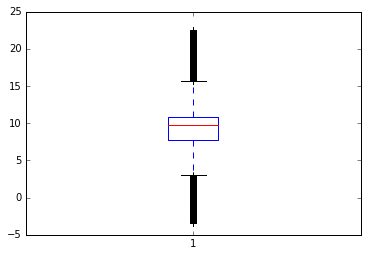

In [13]:
plt.boxplot(df['pct_inc16'])
plt.show()

In [14]:
q1 = df.pct_inc16.quantile(0.25)
q3 = df.pct_inc16.quantile(0.75)

In [15]:
permits_2015 = pd.read_csv('data/permits_2015.csv')
permits_2015.columns

permits_2015['Value'] = permits_2015['Value'].replace('[$]', '', regex=True).astype(float)

In [16]:
def get_permit_count(df, hood, category):
    return df.loc[(df['Neighborhood'] == hood) & (df['Category'] == category), 'Value'].count()

In [17]:
def get_permit_sum(df, hood, category):
    return df.loc[(df['Neighborhood'] == hood) & (df['Category'] == category), 'Value'].sum()

In [18]:
neighborhoods = df['hood'].unique()
permit_categories = permits_2015['Category'].unique()
permit_array = np.empty((len(neighborhoods), len(permit_categories) * 2))

for i, hood in enumerate(neighborhoods):
    for j, cat in enumerate(permit_categories):
        permit_array[i, j] = get_permit_count(permits_2015, hood, cat)
        permit_array[i, j + len(permit_categories)] = get_permit_sum(permits_2015, hood, cat)


In [19]:
a = np.empty((len(df['hood']), permit_array.shape[1]))
for i, hood in enumerate(df['hood']):
    a[i,:] = permit_array[neighborhoods == hood, :]

In [20]:
for i, pc in enumerate(permit_categories):
    df['{}_ct'.format(pc)] = a[:, i]
    df['{}_sum'.format(pc)] = a[:, i + len(permit_categories)]
print df.columns

Index([u'v2014', u'v2015', u'v2016', u'hood', u'year', u'sq_ft', u'beds',
       u'baths', u'lot_size', u'pct_inc15', u'pct_inc16', u'COMMERCIAL_ct',
       u'COMMERCIAL_sum', u'SINGLE FAMILY / DUPLEX_ct',
       u'SINGLE FAMILY / DUPLEX_sum', u'MULTIFAMILY_ct', u'MULTIFAMILY_sum',
       u'INSTITUTIONAL_ct', u'INSTITUTIONAL_sum', u'INDUSTRIAL_ct',
       u'INDUSTRIAL_sum'],
      dtype='object')


In [21]:
df_hood = pd.get_dummies(df['hood'])
df_new = pd.concat([df, df_hood], axis=1)
df_new.drop('hood', axis=1, inplace=True)

In [22]:
y = df_new['pct_inc16']
X = df_new.drop(['v2016', 'pct_inc16'], axis=1)

In [23]:
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
print model.score(X_test, y_test)

lm = sm.OLS(y_train, X_train).fit()
summary = lm.summary()
print summary

0.401641680084
                            OLS Regression Results                            
Dep. Variable:              pct_inc16   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     11.73
Date:                Wed, 28 Dec 2016   Prob (F-statistic):          1.32e-170
Time:                        21:35:18   Log-Likelihood:                -88720.
No. Observations:               23762   AIC:                         1.776e+05
Df Residuals:                   23666   BIC:                         1.784e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0041      0.957     

In [22]:
def grid_search(est, grid):
    grid_cv = GridSearchCV(est, grid, n_jobs=-1, verbose=False).fit(X_train, y_train)
    return grid_cv

In [102]:
gd_grid = {'learning_rate': [0.058],
           'max_depth': [21, 26, 30, 34, 39],
           'min_samples_leaf': [13, 14, 15, 16],
           'max_features': [0.25, 0.245, 0.24, 0.235],
           'n_estimators': [100],
           'random_state': [1]}


gd_grid_search = grid_search(GradientBoostingRegressor(), gd_grid)

In [103]:
gd_best = gd_grid_search.best_estimator_
gd_grid_search.best_params_

{'learning_rate': 0.058,
 'max_depth': 30,
 'max_features': 0.245,
 'min_samples_leaf': 14,
 'n_estimators': 100,
 'random_state': 1}

In [31]:
model = GradientBoostingRegressor(learning_rate=0.058, max_depth=30, max_features=0.245, min_samples_leaf=14,
                                  n_estimators=100)
model.fit(X_train, y_train)
print model.score(X_test, y_test)

0.607399573955


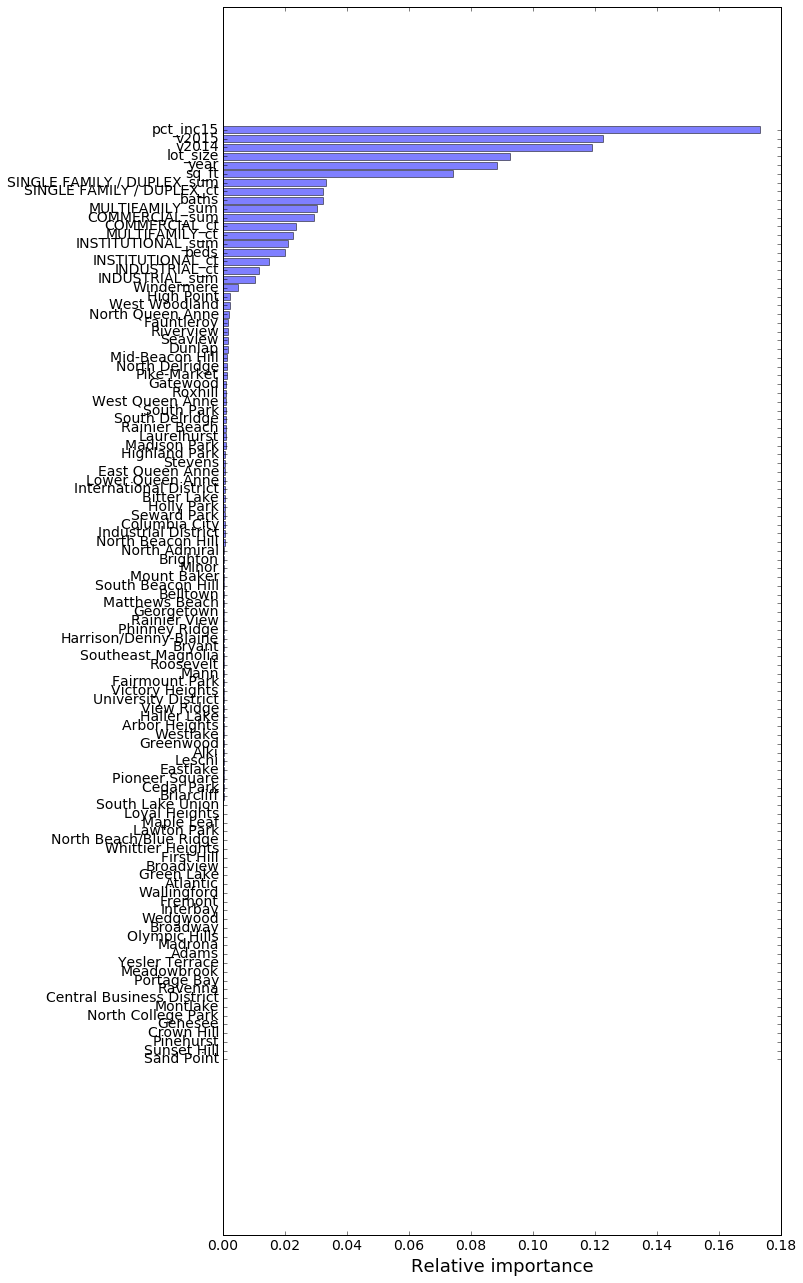

In [66]:
X1 = df_new.drop(['v2016', 'pct_inc16'], axis=1)
col_names = list(X1.columns)
indices = np.argsort(model.feature_importances_)
# plot as bar chart
figure = plt.figure(figsize=(10,22))
plt.barh(np.arange(len(col_names)), model.feature_importances_[indices], align='center', alpha=.5)
plt.yticks(np.arange(len(col_names)), np.array(col_names)[indices], fontsize=14)
plt.xticks(fontsize=14)
_ = plt.xlabel('Relative importance', fontsize=18)

array(['pct_inc15', 'v2015', 'v2014', 'lot_size', 'year', 'sq_ft',
       'SINGLE FAMILY / DUPLEX_sum', 'SINGLE FAMILY / DUPLEX_ct', 'baths',
       'MULTIFAMILY_sum', 'COMMERCIAL_sum', 'COMMERCIAL_ct',
       'MULTIFAMILY_ct', 'INSTITUTIONAL_sum', 'beds', 'INSTITUTIONAL_ct',
       'INDUSTRIAL_ct', 'INDUSTRIAL_sum', 'Windermere', 'High Point',
       'West Woodland', 'North Queen Anne', 'Fauntleroy', 'Riverview',
       'Seaview', 'Dunlap', 'Mid-Beacon Hill', 'North Delridge',
       'Pike-Market', 'Gatewood', 'Roxhill', 'West Queen Anne',
       'South Park', 'South Delridge', 'Rainier Beach', 'Laurelhurst',
       'Madison Park', 'Highland Park', 'Stevens', 'East Queen Anne',
       'Lower Queen Anne', 'International District', 'Bitter Lake',
       'Holly Park', 'Seward Park', 'Columbia City', 'Industrial District',
       'North Beacon Hill', 'North Admiral', 'Brighton', 'Minor',
       'Mount Baker', 'South Beacon Hill', 'Belltown', 'Matthews Beach',
       'Georgetown', 'Rainier

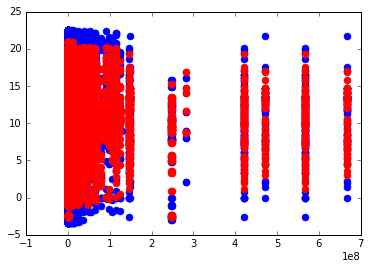

In [98]:
y_pred = model.predict(X_test)
plt.plot(X_test, y_test, 'b.', markersize=14)
plt.plot(X_test, y_pred, 'r.', markersize=14, alpha=0.5)
plt.show()

In [ ]:
breaks = [0.] + [4., 24., 64., 135.] + [1e20]
def self_categorize(entry, breaks):
    for i in range(len(breaks)-1):
        if entry > breaks[i] and entry <= breaks[i+1]:
            return i
    return -1
df_map['jenks_bins'] = df_map.hood_hours.apply(self_categorize, args=(breaks,))

labels = ['Never been\nhere']+["> %d hours"%(perc) for perc in breaks[:-1]]

# Or, you could always use Natural_Breaks to calculate your breaks for you:
# from pysal.esda.mapclassify import Natural_Breaks
# breaks = Natural_Breaks(df_map[df_map['hood_hours'] > 0].hood_hours, initial=300, k=3)
# df_map['jenks_bins'] = -1 #default value if no data exists for this bin
# df_map['jenks_bins'][df_map.hood_count > 0] = breaks.yb
# 
# jenks_labels = ['Never been here', "> 0 hours"]+["> %d hours"%(perc) for perc in breaks.bins[:-1]]

def custom_colorbar(cmap, ncolors, labels, **kwargs):    
    """Create a custom, discretized colorbar with correctly formatted/aligned labels.
    
    cmap: the matplotlib colormap object you plan on using for your graph
    ncolors: (int) the number of discrete colors available
    labels: the list of labels for the colorbar. Should be the same length as ncolors.
    """
    from matplotlib.colors import BoundaryNorm
    from matplotlib.cm import ScalarMappable
        
    norm = BoundaryNorm(range(0, ncolors), cmap.N)
    mappable = ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors+1)+0.5)
    colorbar.set_ticklabels(range(0, ncolors))
    colorbar.set_ticklabels(labels)
    return colorbar

figwidth = 14
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

cmap = plt.get_cmap('Blues')
# draw neighborhoods with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#111111', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# apply our custom color values onto the patch collection
cmap_list = [cmap(val) for val in (df_map.jenks_bins.values - df_map.jenks_bins.values.min())/(
                  df_map.jenks_bins.values.max()-float(df_map.jenks_bins.values.min()))]
pc.set_facecolor(cmap_list)
ax.add_collection(pc)

#Draw a map scale
m.drawmapscale(coords[0] + 0.08, coords[1] + -0.01,
    coords[0], coords[1], 10.,
    fontsize=16, barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
    zorder=5, ax=ax,)

# ncolors+1 because we're using a "zero-th" color
cbar = custom_colorbar(cmap, ncolors=len(jenks_labels)+1, labels=jenks_labels, shrink=0.5)
cbar.ax.tick_params(labelsize=16)

fig.suptitle("Time Spent in Seattle Neighborhoods", fontdict={'size':24, 'fontweight':'bold'}, y=0.92)
ax.set_title("Using location data collected from my Android phone via Google Takeout", fontsize=14, y=0.98)
qax.text(1.35, 0.04, "Collected from 2012-2014 on Android 4.2-4.4\nGeographic data provided by data.seattle.gov", 
    ha='right', color='#555555', style='italic', transform=ax.transAxes)
ax.text(1.35, 0.01, "BeneathData.com", color='#555555', fontsize=16, ha='right', transform=ax.transAxes)

plt.savefig('chloropleth.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')

### Load building permit data and clean dataframe

In [ ]:
# df_permits = pd.read_csv('data/permitting.csv')  # Load the data from csv
# dates = pd.to_datetime(df_permits['Application Date'])  # Convert Application Date column to datetime
# df_permits['year'] = [d.year for d in dates]   # Retrieve year from date and add year column to dataframe

In [ ]:
# df_permits = df_permits[df_permits.year == 2015]  # keep all 2015 data
# df_permits.dropna(axis=0, subset=['Latitude', 'Longitude'], inplace=True)  # drop rows with no latitude and longitude
# print df_permits.head()

In [ ]:
# lons = df_permits['Longitude']
# lats = df_permits['Latitude']

# print len(lons)
# print len(lats)

In [ ]:
from __future__ import division
import psycopg2
import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
import matplotlib
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from descartes import PolygonPatch
import matplotlib.pyplot as plt
from collections import defaultdict
# from matplotlib.path.Path import contains_points


def parse_shapes(shapefilepath):
    '''Read in a shape file (.shp) and return coordinates and dataframe for plotting'''
    shp = fiona.open(shapefilepath+'.shp')
    coords = shp.bounds
    shp.close
    return coords


def plot_prepper(m, shapefilename, df_key):
    '''Generate dataframe for plotting'''
    _out = m.readshapefile(shapefilename, name='seattle', drawbounds=False, color='none', zorder=2)
    # set up a map dataframe for neighborhood outlines
    cent_lons = [float((Polygon(points).centroid.wkt).split()[1][1:]) for points in m.seattle]
    cent_lats = [float((Polygon(points).centroid.wkt).strip(')').split()[2]) for points in m.seattle]

    df = pd.DataFrame({
        'poly': [Polygon(points) for points in m.seattle],
        'name': [item[df_key] for item in m.seattle_info],
    })
    df['centroid_1'] = cent_lons
    df['centroid_2'] = cent_lats
    return _out, df

# Read in neighborhood shape file

hood_shapefilename = '/Users/sydneydecoto/Documents/PythonScripts/Neighborhoods/WGS84/Neighborhoods'
hood_coords = parse_shapes(hood_shapefilename)

w, h = hood_coords[2] - hood_coords[0], hood_coords[3] - hood_coords[1]
extra = 0.005

# Initialize the plot
figwidth = 8
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([hood_coords[0], hood_coords[2]]),
    lat_0=np.mean([hood_coords[1], hood_coords[3]]),
    llcrnrlon=hood_coords[0] - extra * w,
    llcrnrlat=hood_coords[1] - (extra * h),
    urcrnrlon=hood_coords[2] + extra * w,
    urcrnrlat=hood_coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)

# get dataframe for plotting
_out, df_map = plot_prepper(m, hood_shapefilename, 'S_HOOD')
nbr_names = df_map['name'].unique()

pt = []
labels = []
count = 0

pt = [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(lons, lats)]

# for mapped_x, mapped_y in zip(lons, lats):
#     count = count + 1
#     xpt, ypt = m(mapped_x, mapped_y)
#     pt.append(Point(xpt, ypt))
#     for polygon in df_map['poly']:
#         nm = df_map.loc[df_map['poly'] == polygon, 'name'].iloc[0]
#         if polygon.contains(Point(xpt, ypt)) and len(nm.strip()) >= 4:
#             print count
#             labels.append(nm)
#             continue




In [ ]:
# def get_neighborhood(p):
#     label = 'no neighborhood'
#     for polygon in df_map['poly']:
#         nm = df_map.loc[df_map['poly'] == polygon, 'name'].iloc[0]
#         if polygon.contains(p) and len(nm.strip()) >= 4:
#             print nm
#             return nm
#     return label

In [ ]:
# pool = multiprocessing.Pool(4)
# output = pool.map(get_neighborhood, pt)

In [ ]:
# l = get_neighborhood(pt[0])

In [ ]:
# print l

In [ ]:
# df_permits['Neighborhood'] = output

In [ ]:
# df_permits.to_csv('data/permits_2015.csv')

In [94]:
def reduce_directions(dirlist):
    dirs = ''
    s_ct = dirlist.count('SOUTH')
    n_ct = dirlist.count('NORTH')
    e_ct = dirlist.count('EAST')
    w_ct = dirlist.count('WEST')
    
    if s_ct > n_ct:
        dirs += ('SOUTH,' * (s_ct - n_ct))
    else:
        dirs += ('NORTH,' * (n_ct - s_ct))
    if e_ct > w_ct:
        dirs+=('EAST,' * (e_ct - w_ct))
    else:
        dirs+=('WEST,' * (w_ct - e_ct))
    return dirs.strip(',').split('n,')
print reduce_directions(['EAST', 'NORTH', 'SOUTH'])

['EAST']


In [97]:
string = 'saveChangesInTheEditor'
uppers = [c for c in string if c.upper() == c]
print len(uppers) + 1

5
